In [1]:
#importing same packages as my last project
import os
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette("flare", as_cmap=True)

import keras
from keras.models import Model, Sequential
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

#!pip install efficientnet <---installed

import efficientnet.keras as efn
from keras import regularizers 
from keras.regularizers import l2

import keras.backend

import cv2


from skimage.io import imread
from skimage.transform import resize
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

np.random.seed(21)

In [15]:
main_dir = 'C:\\Users\\15164\\Desktop\\sc_images\\'
data_directory = os.listdir('C:\\Users\\15164\\Desktop\\sc_images\\')
print(data_directory)

['test', 'train']


In [16]:
for _set in ['test', 'train']:
    x_benign = len(os.listdir(main_dir + _set + '/benign'))
    x_malignant = len(os.listdir(main_dir + _set + '/malignant'))
    print('Set: {}, Benign Images: {}, Malignant Images: {}, Total: {}'.format(_set, x_benign,
                                                                                x_malignant, (x_benign + x_malignant)))

Set: test, Benign Images: 2912, Malignant Images: 2710, Total: 5622
Set: train, Benign Images: 11644, Malignant Images: 10840, Total: 22484


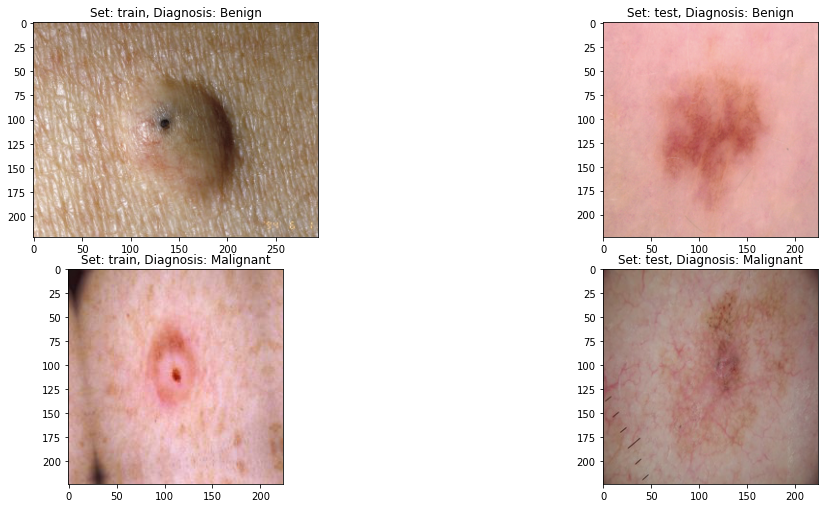

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = main_dir+_set
    ax[i].imshow(plt.imread(set_path+'/benign/'+os.listdir(set_path+'/benign')[0]), cmap='gist_gray')
    ax[i].set_title('Set: {}, Diagnosis: Benign'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/malignant/'+os.listdir(set_path+'/malignant')[0]), cmap='gist_gray')
    ax[i+2].set_title('Set: {}, Diagnosis: Malignant'.format(_set))

# Model 1

In [18]:
train_dir = os.path.join(main_dir, "train\\")
test_dir = os.path.join(main_dir, "test\\")

In [19]:
#Train data:
train_df = []

benign_set = os.path.join(train_dir,'benign')
malignant_set = os.path.join(train_dir,'malignant')

#Image list:

benign_images = glob(benign_set+"/*.jpg") + glob(benign_set+"/*.jpeg") + glob(benign_set+"/*.png")
malignant_images = glob(malignant_set + "/*.jpg") + glob(malignant_set + "/*.jpeg") + glob(malignant_set + "/*.png")

#Benign scans are labeled 0:
for img in benign_images:
    train_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    train_df.append((img, 1))

#Creating a dataframe:
train_df = pd.DataFrame(train_df, columns=['Image', 'Diagnosis'], index=None)

In [20]:
#Test data:
test_df = []

benign_set = os.path.join(test_dir,'benign')
malignant_set = os.path.join(test_dir,'malignant')

#Image list:
benign_images = glob(benign_set+"/*.jpg") + glob(benign_set+"/*.jpeg") + glob(benign_set+"/*.png")
malignant_images = glob(malignant_set + "/*.jpg") + glob(malignant_set + "/*.jpeg") + glob(malignant_set + "/*.png")

#Benign scans are labeled 0:
for img in benign_images:
    test_df.append((img, 0))

#Malignant are labeled 1:
for img in malignant_images:
    test_df.append((img, 1))

#Create the dataframe:
test_df = pd.DataFrame(test_df, columns=['Image', 'Diagnosis'], index=None)

## Plotting Binary Data:

In [21]:
def balance_check(data):
#'data': the dfs we've created
    image_count = data['Diagnosis'].value_counts()
    print('Counts:')
    print(image_count)
    
    plt.figure(figsize=(11,7))
    sns.barplot(x= image_count.index, y= image_count.values)
    plt.title('Plot of Diagnosis Balancing', fontsize= 14)
    plt.xlabel('Diagnosis', fontsize= 11)
    plt.ylabel('Image Count', fontsize= 11)
    plt.xticks(range(len(image_count.index)), ['Benign(0)', 'Malignant(1)'])
    plt.show()

In [22]:
train_df['Diagnosis'].value_counts()

0    11644
1    10840
Name: Diagnosis, dtype: int64

Counts:
0    11644
1    10840
Name: Diagnosis, dtype: int64


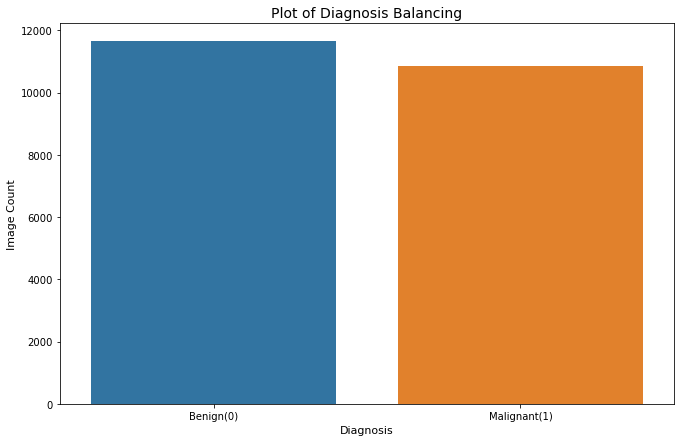

In [23]:
balance_check(train_df)

Counts:
0    2912
1    2710
Name: Diagnosis, dtype: int64


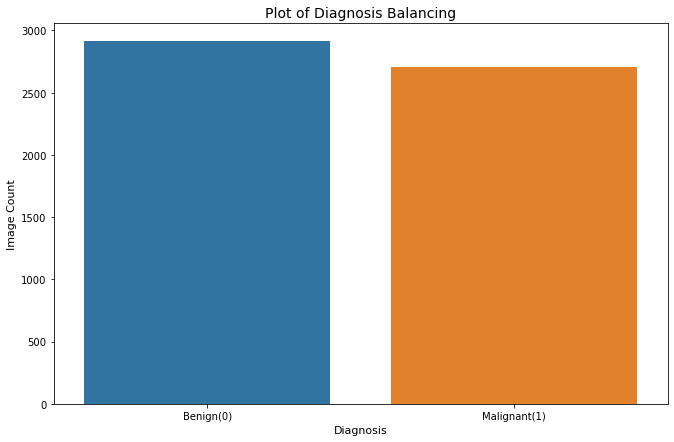

In [24]:
balance_check(test_df)

# Model 1:

## Image Augmentation

In [25]:
def data_processing(img_dims, batch_size):
    train_data_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_data_gen = ImageDataGenerator(rescale=1./255) #scaling the images to the same range [0,1]
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_generator = train_data_gen.flow_from_directory(
    directory=main_dir+'train', 
    target_size=(img_dims, img_dims),  #Each image will be resized to this size
    batch_size=batch_size, #number of observations that are inputted into the model at one time
    class_mode='binary', 
    shuffle=True)

    test_generator = test_data_gen.flow_from_directory(
    directory=main_dir+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=False)
    
    # In order to plot the Confusion Matrix, I will be making predictions off of the test set in one batch size
    test_data = []
    test_labels = []

    for cond in ['/benign/', '/malignant/']:
        for img in (os.listdir(main_dir + 'test' + cond)):
            img = plt.imread(main_dir+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/benign/':
                label = 0
            elif cond=='/malignant/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_generator, test_generator, test_data, test_labels

In [26]:
import cv2
#Values for later use:
img_dims = 150
epochs = 30
batch_size = 10
train_generator, test_generator, test_data, test_labels = data_processing(img_dims, batch_size)

Found 22484 images belonging to 2 classes.
Found 5622 images belonging to 2 classes.


### Model Visualization Function:

In [27]:
def model_performance(history):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']#<--'val' here is for validation, and will be from the 'test' dataset
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
    
    #Plotting loss results:    
    epochs = range(1, len(val_loss_values) + 1) #epoch: the number of times the model will be fit on the training set.
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Train Loss')
    
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Val Loss')
    plot1.set(xlabel='Epochs', ylabel='Loss')
    plot1.axes.set_title('Model Loss', fontsize=18)
    plot1.grid(b=True, which='major', axis='y') #To show the grid lines or not
    
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Train Accuracy')
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Val Accuracy')
    plot2.set(xlabel='Epochs', ylabel='Accuracy')
    plot2.axes.set_title('Model Accuracy', fontsize=20)
    plot2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

# CNN Model

In [28]:
inputs = Input(shape=(img_dims, img_dims, 3))

#1st Convolution
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#2nd Convolution
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#3rd Convolution
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#4th Convolution
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

#5th Convolution
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #<--Converting a real value into a interpretable probability

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [29]:
hist = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, 
           epochs=epochs, validation_data=test_generator, shuffle=True,
           validation_steps=test_generator.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/30
2248/2248 [==============================] - 1082s 481ms/step - loss: 0.5669 - accuracy: 0.7108 - val_loss: 0.6086 - val_accuracy: 0.6975
Epoch 2/30
2248/2248 [==============================] - 988s 440ms/step - loss: 0.4832 - accuracy: 0.7852 - val_loss: 0.5293 - val_accuracy: 0.6989
Epoch 3/30
2248/2248 [==============================] - 986s 439ms/step - loss: 0.4371 - accuracy: 0.8068 - val_loss: 3.5830 - val_accuracy: 0.5185
Epoch 4/30
2248/2248 [==============================] - 982s 437ms/step - loss: 0.4173 - accuracy: 0.8164 - val_loss: 0.8401 - val_accuracy: 0.5244
Epoch 5/30
2248/2248 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8215
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2248/2248 [==============================] - 997s 444ms/step - loss: 0.4076 - accuracy: 0.8215 - val_loss: 1.3294 - val_accuracy: 0.6601
Epoch 6/30
2248/2248 [==============================] - 1110s 494ms/step - loss: 0.3633 - ac

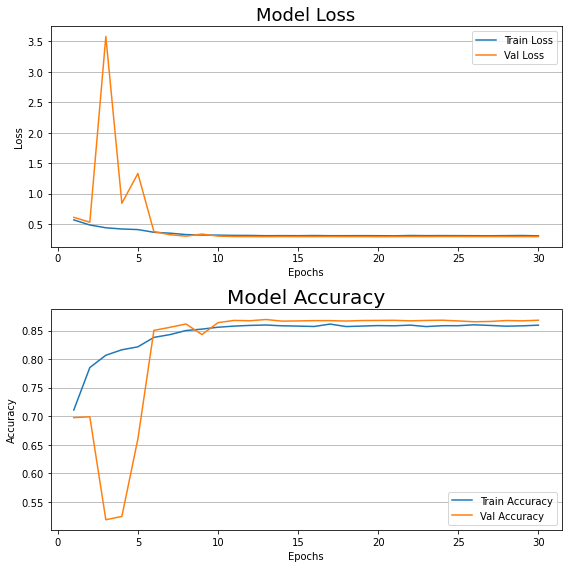

In [30]:
model_performance(hist)

In [31]:
preds = model.predict(test_generator)

accur = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative


print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[2682  230]
 [ 512 2198]]

TEST METRICS ----------------------
Accuracy: 86.80184987548914%
Precision: 90.52718286655683%
Recall: 81.1070110701107%
F1-score: 85.55858310626702

TRAIN METRIC ----------------------
Train Accuracy: 85.95


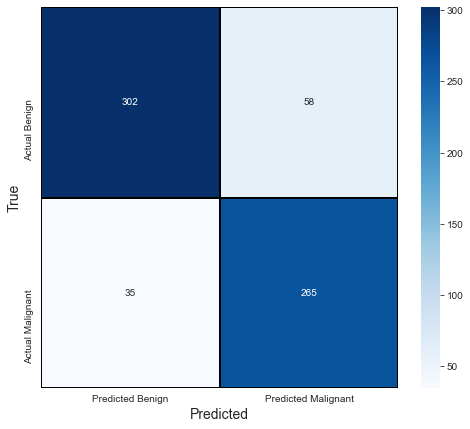

In [26]:
cm = pd.DataFrame(cm, index = ['Actual Benign', 'Actual Malignant'], columns = ['Predicted Benign', 'Predicted Malignant'])
plt.figure(figsize = (8,7))
labels = ['Benign', 'Malignant']
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()


# Model 2:

In [24]:
#To free up memory space:
tf.keras.backend.clear_session()

In [4]:
def resize_images(directory, resize):
    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for image_name in os.listdir(directory):
        PATH = os.path.join(directory, image_name)
        _, ftype = os.path.splitext(PATH)
        if ftype.endswith((".jpg", ".jpeg", ".png")):
            img = read(PATH)
            img = cv2.resize(img, (resize, resize))
            images.append(np.array(img)/255.)
    return images

In [5]:
benign_train = np.array(resize_images('C:\\Users\\15164\\Desktop\\sc_images\\train\\benign', 150))

In [6]:
malign_train = np.array(resize_images('C:\\Users\\15164\\Desktop\\sc_images\\train\\malignant', 150))

In [7]:
benign_test = np.array(resize_images('C:\\Users\\15164\\Desktop\\sc_images\\test\\benign', 150))

In [8]:
malign_test = np.array(resize_images('C:\\Users\\15164\\Desktop\\sc_images\\train\\malignant', 150))

In [9]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merging
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [10]:
# Shuffling train data
sh = np.arange(x_train.shape[0])
np.random.shuffle(sh)
x_train = x_train[sh]
y_train = y_train[sh]

# Shuffling test data
sh = np.arange(x_test.shape[0])
np.random.shuffle(sh)
x_test = x_test[sh]
y_test = y_test[sh]

In [11]:
# Splitting validation set from train set
x_train=x_train[500:]
x_val=x_train[:500]
y_train=y_train[500:]
y_val=y_train[:500]

In [12]:
x_test.shape, x_val.shape, x_train.shape #<---Checking the code's success:

((13752, 150, 150, 3), (500, 150, 150, 3), (21984, 150, 150, 3))

In [13]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)
y_val = to_categorical(y_val, num_classes= 2)

In [25]:
# normalization 
#x_train = x_train/255.
#x_test = x_test/255.
#x_val = x_val/255.

#Rechecking shape:
#x_test.shape, x_val.shape, x_train.shape

MemoryError: Unable to allocate 11.1 GiB for an array with shape (21984, 150, 150, 3) and data type float64

In [14]:
datagen = ImageDataGenerator(rotation_range=45, zoom_range = 0.1, width_shift_range=0.2, height_shift_range=0.2, 
                             horizontal_flip=True, vertical_flip=True)

In [15]:
eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model2=Sequential()
model2.add(eff_net)
model2.add(layers.GlobalAveragePooling2D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(2, activation='softmax'))

alpha = 1e-3
for layer in model2.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))


model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 5, 5, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 4,214,302
Trainable params: 4,172,030
Non-trainable params: 42,272
_________________________________________

In [16]:
#lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, mode='max')

reduce_lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=0, mode='auto', min_delta=0.0001,
                             cooldown=0, min_lr=0)

checkpoint = ModelCheckpoint(filepath='best_weights2.hdf5', save_best_only=True, save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=15, mode='max')

optimizer= Adam(lr=0.0001)

In [17]:
# Shuffling train data again
#sh = np.arange(x_train.shape[0])
#np.random.shuffle(sh)
#x_train = x_train[sh]
#y_train = y_train[sh]

# Shuffling test data
#sh = np.arange(x_test.shape[0])
#np.random.shuffle(sh)
#x_test = x_test[sh]
#y_test = y_test[sh]

# Shuffling validation data to avoid overfitting the model:
sh = np.arange(x_val.shape[0])
np.random.shuffle(sh)
x_val = x_val[sh]
y_val = y_val[sh]


In [ ]:
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
hist = model2.fit(datagen.flow(x_train,y_train, batch_size=10),epochs=30, 
                  validation_data=(x_val, y_val),callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/30
2199/2199 [==============================] - 1945s 884ms/step - loss: 0.3979 - accuracy: 0.8305 - val_loss: 0.3356 - val_accuracy: 0.8600
Epoch 2/30
2199/2199 [==============================] - 1936s 880ms/step - loss: 0.3500 - accuracy: 0.8487 - val_loss: 0.3193 - val_accuracy: 0.8680
Epoch 3/30
2199/2199 [==============================] - 1907s 867ms/step - loss: 0.3224 - accuracy: 0.8584 - val_loss: 0.3165 - val_accuracy: 0.8520
Epoch 4/30
2199/2199 [==============================] - 1920s 873ms/step - loss: 0.3147 - accuracy: 0.8643 - val_loss: 0.4589 - val_accuracy: 0.8520
Epoch 5/30
2199/2199 [==============================] - 1890s 859ms/step - loss: 0.3088 - accuracy: 0.8671 - val_loss: 0.4376 - val_accuracy: 0.8640
Epoch 6/30
2199/2199 [==============================] - 1892s 860ms/step - loss: 0.2874 - accuracy: 0.8760 - val_loss: 0.2740 - val_accuracy: 0.8820
Epoch 7/30
2199/2199 [==============================] - 1891s 860ms/step - loss: 0.2735 - accuracy: 0.8810

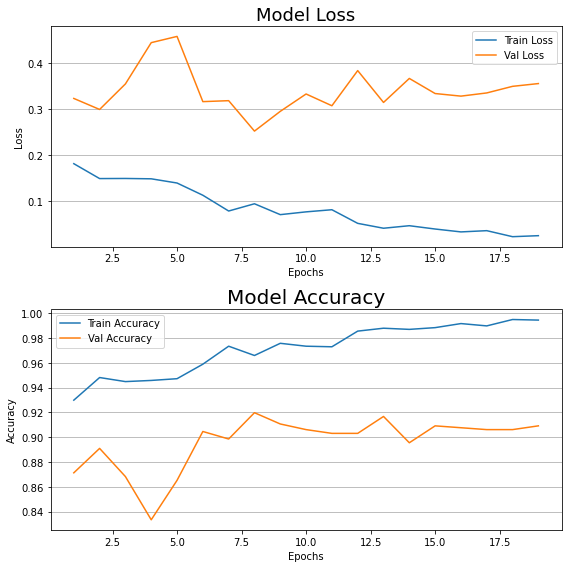

In [57]:
model_performance(hist)

In [ ]:
predictions = model2.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names=['Benign(Class 0)', 'Malignant (Class 1)']))

In [58]:
model2.evaluate(x_train, y_train)

67/67 [==============================] - 60s 890ms/step - loss: 0.0207 - accuracy: 0.9944


[0.020715849474072456, 0.9943846464157104]

In [61]:
model2.evaluate(x_test, y_test)

21/21 [==============================] - 17s 802ms/step - loss: 0.3553 - accuracy: 0.9091


[0.3552718162536621, 0.9090909361839294]